# K means : Introduction and Applications to mnist : Kevin Berlemont

Here we are going to propose a framework for K means method in application to the MNIST database. The algorithm we are going to use is the one of Lloyd/Voronoi. We will try to see the performance of this algorithm, and his "online" behavior to understand how the cluster are compute.



In [5]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>

## I  Introduction on Gaussian mixture

In [1]:
import numpy as np

def random_sample(X, k):
    '''
    Take a random sample of a list X to generate the initial centroids
    '''
    return X[np.random.choice(X.shape[0], k, replace=False),:]

def pairwise_distances_argmin(X, y):
    '''
    Return the closest centroids to the point y
    X are all the centroids
    '''
    indices = np.empty(X.shape[0], dtype=np.intp)
    for i in range(len(X)):
        indices[i] = np.linalg.norm(X[i,np.newaxis] - y, axis=1).argmin()
    return indices

In [2]:
def kmeans_iteration(X, m,distance=pairwise_distances_argmin):
    '''
    One iteration of Lloyd's algorithm
    '''
    clusters = distance(X, m)
    centroids = np.empty(m.shape)
    for i in range(len(m)):
        centroids[i] = np.mean(X[clusters == i], axis=0)
    return centroids, clusters

def kmeans(X, k,m=None,distance=pairwise_distances_argmin):
    '''
    Run K_means until we are close to convergence
    '''
    if m is None : m = random_sample(X, k)
    while True:
        new_m, clusters = kmeans_iteration(X, m,distance)
        if np.isclose(m, new_m).all():
            break
        m = new_m
    return new_m, clusters

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import seaborn as sns

plt.style.use('ggplot')
sns.set_style('whitegrid') # some graphic stuff use in jupyter in python3
rc('figure', figsize=(6, 4))
cmap = cm.get_cmap('rainbow') # colors for cluster

def plot_clusters(X, m, clusters):
    '''
    Plot all the pointsi n the clusters with respective colors
    '''
    k = len(m)
    for i in range(k):
        group = X[clusters == i]
        plt.scatter(group[:,0], group[:,1], marker='.', color=cmap(i / k))
        plt.scatter(m[i,0], m[i,1], marker='s',lw=2,color=cmap(i / k),edgecolor='k')
    plt.show()

/home/kevin/miniconda3/envs/ipykernel_py3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
def classify_cluster(clusters,centroids,X):
    """
    Assigns a digit label to each cluster.
    Cluster is a list of clusters containing labelled datapoints.
    IMPORTANT: this function depends on clusters and centroids being in the same order.
    """
    labelled_centroids = []
    clusters_list = {c: [] for c in range(len(centroids))}
    for i in range(len(clusters)):
        clusters_list[clusters[i]].append((X[i][0],X[i][1]))
    clusters_final = list(clusters_list.values())
    for i in range(len(clusters_final)):
        labels = list(map(lambda x: x[0], clusters_final[i]))
        # pick the most common label
        most_common = max(set(labels), key=labels.count)
        centroid = (most_common, centroids[i])
        labelled_centroids.append(centroid)
    return labelled_centroids

def classify_digit(digit, labelled_centroids):
    """
    given an unlabelled digit represented by a vector and a list of
    labelled centroids [(label,vector)], determine the closest centroid
    and thus classify the digit.
    """
    mindistance = float("inf")
    for (label, centroid) in labelled_centroids:
        distance = np.linalg.norm(centroid - digit)
        if distance < mindistance:
            mindistance = distance
            closest_centroid_label = label
    return closest_centroid_label

def get_error_rate(digits,labelled_centroids):
    """
    classifies a list of labelled digits. returns the error rate.
    """
    classified_incorrect = 0
    for (label,digit) in digits:
        classified_label = classify_digit(digit, labelled_centroids)
        if classified_label != label:
            classified_incorrect +=1
    error_rate = classified_incorrect / float(len(digits))
    return error_rate
        

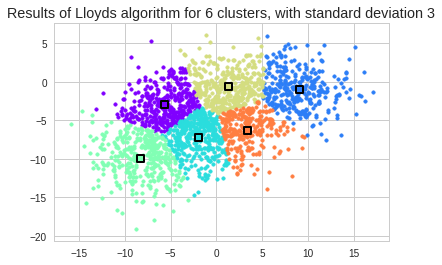

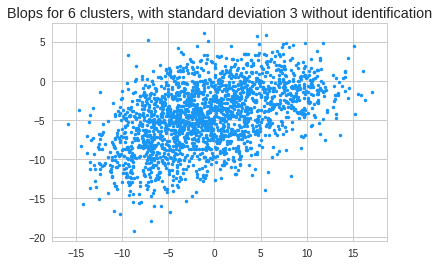

In [5]:
from sklearn.datasets import make_blobs
%matplotlib inline
k=6 # Number of centers
sigma = 3 # Std deviation


X, label = make_blobs(n_samples=2000, centers=k, cluster_std=sigma)
m, clusters = kmeans(X, k)
plt.title('Results of Lloyds algorithm for {} clusters, with standard deviation {}' .format(k,sigma))
plot_clusters(X, m, clusters)

#Without cluster classification
plt.plot(X[:,0], X[:,1],
         linestyle='', marker='.',
         color=cmap(0.2), markeredgecolor=cmap(0.25))
plt.title('Blops for {} clusters, with standard deviation {} without identification' .format(k,sigma))
plt.show()


Commentaires de la figure

### Animation

In [5]:
import matplotlib.animation as animation

class KMeansAnimation:
    def __init__(self, fig, ax, X, m=None, k=2):
        self.X = X
        self.fig = fig
        self.m = m if m is not None else random_sample(X, k)
        # We have to call plot for each cluster and its centroid
        # because we want to distinguish the clusters by color
        # and draw the centroid with a different marker
        self.clusters, self.centroids = [], []
        for i in range(k):
            color = cmap(i / k)
            self.clusters.append(
                ax.plot([], [],
                        linestyle='', marker='.',
                        markeredgecolor=color, color=color)[0]
            )
            self.centroids.append(
                ax.plot([], [],
                        linestyle='', marker='s',
                        markeredgewidth=1,
                        markersize=8, color=color,markeredgecolor='k')[0]
            )

    def update(self, t):
        self.m, clusters = kmeans_iteration(self.X, self.m)
        self.fig.suptitle('n = {}, centers = {} – Iteration {}'.format(
                len(self.X), len(self.m), t + 1)
        )
        # To update the plot, we simply call set_data on the saved axes
        for i in range(len(self.m)):
            group = self.X[clusters == i]
            self.clusters[i].set_data(group.T)
            self.centroids[i].set_data(self.m[i])
        return self.clusters + self.centroids

In [6]:
from IPython.display import HTML

def make_animation(X, k, m=None, frames=20):
    '''
    display animation in jupyter notebook
    '''
    fig = plt.figure(figsize=(6, 4))
    (xmin, ymin), (xmax, ymax) = np.min(X, axis=0), np.max(X, axis=0)
    ax = plt.axes(xlim=(xmin, xmax), ylim=(ymin, ymax))
    control = KMeansAnimation(fig, ax, X, m=m, k=k)
    anim = animation.FuncAnimation(
        fig, control.update,
        frames=frames, interval=700, blit=True,
    )
    # Necessary, otherwise the notebook will display the final figure
    # along with the animation
    plt.close(fig)
    return HTML(anim.to_html5_video())

In [7]:
k=6 # Number of blops
sigma = 3 # Std deviation


X,_ = make_blobs(n_samples=2000, centers=k, cluster_std=sigma)
print ('Results of Lloyds algorithm for {} clusters, with standard deviation {}, with less centers than blops' .format(k,sigma))
make_animation(X, k=4, frames=20)

Results of Lloyds algorithm for 6 clusters, with standard deviation 3, with less centers than blops


Expplain what happens. But what happens for point together or dense distribution ????? and explain why more blops than centers

In [8]:
k=6
sigma=2.2
X, _ = make_blobs(n_samples=2000, centers=6, cluster_std=2.2)
m = np.array([[0, 2.5], [3, 11], [4, 10], [5.5, 2]])
print ('Results of Lloyds algorithm for {} blops, with standard deviation {}, with close centroids at time 0' .format(k,sigma))
make_animation(X, k=4,m=m, frames=20)

Results of Lloyds algorithm for 6 blops, with standard deviation 2.2, with close centroids at time 0


In [9]:
X_dense = np.random.rand(2000, 2)
make_animation(X_dense, k=11)

A word on Voronoi tesselation ?????? et peut êter le taux d'erreurs non ??

### N-D algo

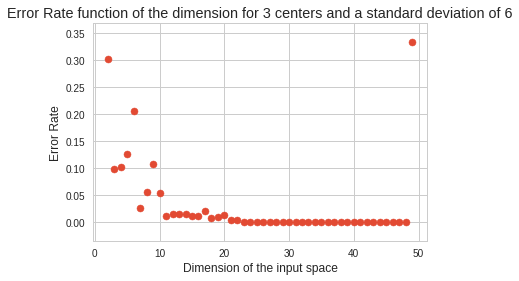

In [32]:
# Define the list of the variables : dimensions,standard deviation 
list_sigma=np.arange(1.5,6,0.1)
list_dimensions = np.arange(2,50,1)
list_error_rates=np.zeros(len(list_dimensions))
k=3 # Number of centers
sigma=6
for i,dim in enumerate(list_dimensions):
    
    X, label = make_blobs(n_samples=2000, centers=k,n_features=dim, cluster_std=sigma)
    X_final=list(zip(label,X))
    m, clusters = kmeans(X, k)
    labelled_centroids = classify_cluster(clusters,m,X_final)
    error_rate = get_error_rate(X_final, labelled_centroids)
    list_error_rates[i]=error_rate


# Grpahic plot
x_axis=list_dimensions
y_axis = list_error_rates
plt.figure()
plt.title("Error Rate function of the dimension for {} centers and a standard deviation of {}".format(k,sigma))
plt.scatter(x_axis, y_axis)
plt.xlabel("Dimension of the input space")
plt.ylabel("Error Rate")
plt.show()

In [45]:
# Define the list of the variables : dimensions,standard deviation and number of centers 
list_sigma=np.arange(4,12,2)
list_dimensions = np.arange(2,50,10)
list_centers=np.arange(2,50,10)

list_error_rates=np.zeros((len(list_dimensions),len(list_centers),len(list_sigma))) # Full results


for k,centers in enumerate(list_centers):                          
 for j,sigma in enumerate(list_sigma):
  for i,dim in enumerate(list_dimensions):
    
   
    X, label = make_blobs(n_samples=2000, centers=centers,n_features=dim, cluster_std=sigma)
    X_final=list(zip(label,X))
    m, clusters = kmeans(X, centers)
    labelled_centroids = classify_cluster(clusters,m,X_final)
    error_rate = get_error_rate(X_final, labelled_centroids)
    list_error_rates[i,k,j]=error_rate


In [46]:
#Graphic packages
import plotly as plotly # New package on grpahics, really good in 3D and to move graphs
plotly.tools.set_credentials_file(username='Kazoo', api_key='fVOEm7jiacAQuzw7juG0') # Just for reinitialization of the API key

from plotly.graph_objs import *
import plotly.plotly as py
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True) # Allow to plot the graphs in the notebook


In [78]:
# Plot of the full data
z1=list_error_rates[:,:,0]
z2=list_error_rates[:,:,1]+1
z3=list_error_rates[:,:,2]+2
z4=list_error_rates[:,:,3]+3
init_notebook_mode(connected=True)

layout = Layout(dict(title = 'Error rates of the K-means Algorithms',
        scene=dict(
            
        xaxis= dict(
            title= 'Dimension',
            ticklen= 7,
            zeroline= False,
            gridwidth= 2,
            ticktext= list_dimensions,
            tickvals=np.arange(0,len(list_dimensions),1),),
        yaxis=dict(
            
            title= 'Nbr centres',
            ticklen= 7,
            gridwidth= 2,
            ticktext= list_centers,
            tickvals=np.arange(0,len(list_centers),1),
    ),
        zaxis=dict(
            
            title= 'Standard deviation',
            ticklen= 7,
            gridwidth= 2,
            ticktext= list_sigma,
            tickvals=np.arange(0,len(list_sigma),1),
    ),
        ),
              showlegend=True))

    
data=Data([
    dict(z=z1, type='surface',name='Sigma= '+str(list_sigma[0]),colorbar = dict(
            title = "Error rate at the end")),
    dict(z=z2, showscale=False, opacity=1, type='surface',name='Sigma = '+str(list_sigma[1])),
    dict(z=z3, showscale=False, opacity=1, type='surface',name='Sigma = '+str(list_sigma[2])),
    dict(z=z4, showscale=False, opacity=1, type='surface',name='Sigma = '+str(list_sigma[3])),
    ])
fig = dict(data=data,
    layout=layout
    )

py.iplot(fig, filename='multiple-surfaces-error-rates')

## II  MNIST dataset

Bad results but allow us to plot a 2D graph and animation

### PCA reduced data

In [10]:
import random
from base64 import b64decode
from json import loads
import numpy as np
import matplotlib.pyplot as plt
# set matplotlib to display all plots inline with the notebook
%matplotlib inline

In [11]:
def parse(x):
    """
    to parse the digits file into tuples of 
    (labelled digit, numpy array of vector representation of digit)
    """
    digit = loads(x)
    array = np.fromstring(b64decode(digit["data"]),dtype=np.ubyte)
    array = array.astype(np.float64)
    return (digit["label"], array)

In [12]:
# read in the digits file. Digits is a list of 60,000 tuples,
# each containing a labelled digit and its vector representation.
  
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


with open("digits.base64.json","r") as f:
    digits = list(map(parse, f.readlines()))

data=[]
for i in range(int(len(digits)*0.75)):
    data.append(digits[i][1])
data = scale(data) # scale the datas
reduced_data = PCA(n_components=2).fit_transform(data) # Redced data to plot them in 2D

# Graphics stuff
print ('PCA reduced MNIST Data and K-Means algorithm for 10 cluster')
make_animation(reduced_data, k=10, frames=20)

PCA reduced MNIST Data and K-Means algorithm for 10 cluster


The question we can ask is, Is this classification accurate or does the centroids are kind of random ? 
To do this we will plot the label of a digit as color instead of of the cluster

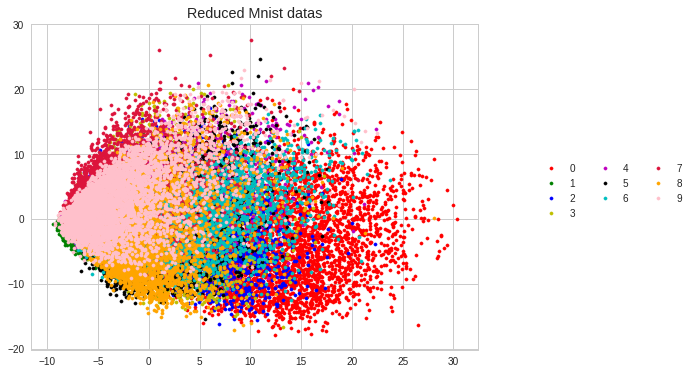

In [123]:

label_digit=list()
for i in range (len(reduced_data)):
    label_digit.append(digits[i][0])
training = zip(label_digit,reduced_data)

plt.figure(1,figsize=(8,6))
colormap=np.array(['r', 'g', 'b','y','m','k','c','crimson','orange','pink'])
for i in range(10): #scatter legend
    
    
    group0 = list() ; group1 = list()
    for k in range(len(reduced_data)):
        if label_digit[k]==i:
            group0.append(reduced_data[k,0])
            group1.append(reduced_data[k,1])
    
    plt.scatter(group0,group1,s=10,c=colormap[i],label=i)

plt.title('Reduced Mnist datas')
plt.legend(loc=9, bbox_to_anchor=(1.3, 0.6), ncol=3)
plt.show()

### Full digits images



In [169]:
#Load all the datas 

with open("digits.base64.json","r") as f:
    digits = list(map(parse, f.readlines()))

# pick a ratio for splitting the digits list into a training and a validation set. Classic is 0.25
ratio = int(len(digits)*0.25)
validation = digits[:ratio]
training = digits[ratio:]

validation_data = np.zeros((ratio,784))
validation_label = np.zeros((ratio,1))
for i in range(ratio):
    validation_data[i] =digits[i][1]
    validation_label[i] = digits[i][0]
    
    
training_data = np.zeros((len(digits)-ratio,784))
training_label = np.zeros((len(digits)-ratio,1))
for i in range(len(digits)-ratio):
    training_data[i] =digits[i+ratio][1]
    training_label[i] = digits[i+ratio][0]


In [164]:
def display_digit(digit, labeled = True, title = ""):
    """ 
    graphically displays a 784x1 vector, representing a digit
    """
    if labeled:
        digit = digit[1]
    image = digit
    plt.figure()
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if title != "":
        plt.title("Inferred label: " + str(title))

In [ ]:
def classify_digit(digit, labelled_centroids):
    """
    given an unlabelled digit represented by a vector and a list of
    labelled centroids [(label,vector)], determine the closest centroid
    and thus classify the digit.
    """
    mindistance = float("inf")
    for (label, centroid) in labelled_centroids:
        distance = np.linalg.norm(centroid - digit)
        if distance < mindistance:
            mindistance = distance
            closest_centroid_label = label
    return closest_centroid_label

def get_error_rate(digits,labelled_centroids):
    """
    classifies a list of labelled digits. returns the error rate.
    """
    classified_incorrect = 0
    for (label,digit) in digits:
        classified_label = classify_digit(digit, labelled_centroids)
        if classified_label != label:
            classified_incorrect +=1
    error_rate = classified_incorrect / float(len(digits))
    return error_rate

In [172]:
def assign_labels_to_centroids(clusters, centroids):
    """
    Assigns a digit label to each cluster.
    Cluster is a list of clusters containing labelled datapoints.
    IMPORTANT: this function depends on clusters and centroids being in the same order.
    """
    labelled_centroids = []
    clusters_list = {c: [] for c in range(len(centroids))}
    for i in range(len(clusters)):
        clusters_list[clusters[i]].append((digits[i+ratio][0],digits[i+ratio][1]))
    clusters_final = list(clusters_list.values())
    for i in range(len(clusters_final)):
        labels = list(map(lambda x: x[0], clusters_final[i]))
        # pick the most common label
        most_common = max(set(labels), key=labels.count)
        centroid = (most_common, centroids[i])
        labelled_centroids.append(centroid)
    return labelled_centroids

In [173]:
k=10
m, clusters = kmeans(training_data, k)
labelled_centroids = assign_labels_to_centroids(clusters,m)
error_rate = get_error_rate(validation, labelled_centroids)



0.4062


In [182]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def print_results(validation,labelled_centroids):
 for i in range(10):
  print (bcolors.BOLD + 'Classification of the digit : ' + str(i) + ' Using ' + str(k) + ' clusters' +bcolors.ENDC)
  label_list = []
  frequency = {x:0 for x in range(10)}

  for (label,digit) in validation:
    inferred_label = classify_digit(digit, labelled_centroids)
    if inferred_label==i:
        label_list.append(digit)
        frequency[label] +=1
        
  print (bcolors.BOLD + "Digit in the cluster        Frequency"+bcolors.ENDC)
  for i in range(len(frequency)):
    print (bcolors.BOLD + str(i) +"                  " + str(frequency[i])+bcolors.ENDC)
    print ('\n')
print_results(validation,labelled_centroids)

Classification of the digit : 0 Using 19 clusters
Digit in the cluster        Frequency
0                  1268
1                  0
2                  19
3                  7
4                  1
5                  20
6                  35
7                  2
8                  9
9                  5
Classification of the digit : 1 Using 19 clusters
Digit in the cluster        Frequency
0                  0
1                  1659
2                  136
3                  53
4                  25
5                  12
6                  39
7                  46
8                  54
9                  13
Classification of the digit : 2 Using 19 clusters
Digit in the cluster        Frequency
0                  1
1                  2
2                  1034
3                  29
4                  2
5                  0
6                  2
7                  4
8                  5
9                  0
Classification of the digit : 3 Using 19 clusters
Digit in the cluster        Freque

As we can see the results are not that good, it depends on which number are we trying to detect.

## III   How to choose the number of cluster

First we can plot the error rate function of the number of cluser. Then we can look at the Gap statistic theory, , a method developed by Tibshirani, Walther and Hastie in 2001.

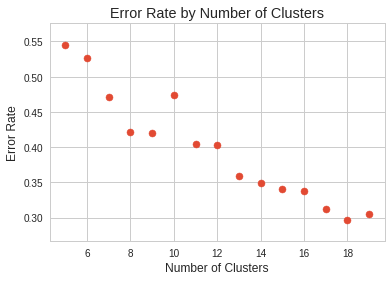

In [178]:
error_rates = {x:None for x in list(range(5,30))}
list_centroids=list()
max_iter=20
for k in range(5,20):
    m, clusters = kmeans(training_data, k)
    labelled_centroids = assign_labels_to_centroids(clusters,m)
    error_rate = get_error_rate(validation, labelled_centroids)
    error_rates[k] = error_rate
    list_centroids.append(m)
# Show the error rates
x_axis = sorted(error_rates.keys())
y_axis = [error_rates[key] for key in x_axis]
plt.figure()
plt.title("Error Rate by Number of Clusters")
plt.scatter(x_axis, y_axis)
plt.xlabel("Number of Clusters")
plt.ylabel("Error Rate")
plt.show()

In [181]:
import pickle as pickle 

with open('data/donnees_kmeans','wb') as fichier:
    my_pickler= pickle.Pickler(fichier)
    my_pickler.dump(error_rates)
    my_pickler.dump(list_centroids)
    readme=['centroids','erreurs']
    my_pickler.dump(readme)

Now let's implement the method :
-------------------------------------------

theorie a mettre

In [13]:
def Wk(X, centroids, clusters):
    """
    Energy of the cluster
    """
    return np.sum([np.linalg.norm(X[i] - centroids[clusters[i]]) ** 2
                   for i in range(len(X))])

def monte_carlo(X, xmin, xmax, ymin, ymax, n=None):
    # n is the sample size
    # monte carlo method in 2-D
    n = n if n is not None else len(X)
    xs = np.random.uniform(xmin, xmax, size=(n, 1))
    ys = np.random.uniform(ymin, ymax, size=(n, 1))
    return np.concatenate([xs, ys], axis=1)

def gap_stats(X, K=8, B=10, n=None):
    """
    Generate all the statistic on the gaps
    It follows directly the method described in the paper
    """
    (xmin, ymin), (xmax, ymax) = np.min(X, axis=0), np.max(X, axis=0)
    ks = np.arange(1, K + 1)
    # Generate B Monte Carlo samples (uniform) from the bounding box of X
    samples = [monte_carlo(X, xmin, xmax, ymin, ymax, n) for _ in range(B)]
    # Total energy of X for each k
    Wks = np.empty(K)
    # Mean total energy of samples for each k
    sample_Wks = np.empty(K)
    # Corrected standard deviation for each k
    sk = np.empty(K)
    for k in ks:
        Wks[k - 1] = np.log(Wk(X, *kmeans(X, k)))
        # Total energy for each sample
        current_Wks = np.empty(B)
        for i in range(B):
            sample = samples[i]
            current_Wks[i] = np.log(Wk(sample, *kmeans(sample, k)))
        sample_Wks[k - 1] = current_Wks.mean()
        sk[k - 1] = np.sqrt(((current_Wks - sample_Wks[k - 1]) ** 2).mean())
    # Correction factor
    sk *= np.sqrt(1 + 1 / B)
    gaps = sample_Wks - Wks
    return ks, Wks, sample_Wks, gaps, sk


import matplotlib.ticker as ticker

def gaps_info(X, ks, Wks, sample_Wks, gaps, sk):
    """
    ALl the plotting options for describing the statistic
    Some help from for the plotting : http://signal-to-noise.xyz/kmeans.html
    """
    fig, axes = plt.subplots(2, 2, figsize=(8, 7))
    axes[0,0].plot(X[:,0], X[:,1],
                   linestyle='', marker='.',
                   color=cmap(0.2), markeredgecolor=cmap(0.25))
    line1, = axes[0,1].plot(ks, Wks, marker='.', markersize=10)
    line2, = axes[0,1].plot(ks, sample_Wks, marker='.', markersize=10)
    axes[0,1].legend(
        (line1, line2),
        (r'$\log W_k$', r'$\frac{1}{B}\sum_{b = 1}^B\,\log W_{kb}^*$')
    )
    axes[1,0].plot(ks, gaps, marker='.', markersize=10)
    axes[1,0].set_ylabel('$\operatorname{Gap}(k)$')
    gaps_diff = gaps[:-1] - gaps[1:] + sk[1:]
    barlist = axes[1,1].bar(ks[:-1], gaps_diff,
                            width=0.5, align='center')
    barlist[np.argmax(gaps_diff > 0)].set_color(sns.xkcd_rgb['pale red'])
    axes[1,1].set_ylabel('$\operatorname{Gap}(k) -'
                         ' \operatorname{Gap}(k + 1) + s_{k + 1}$')
    for (i, j) in ((0, 1), (1, 0), (1, 1)):
        axes[i,j].set_xlabel('Clusters')
        axes[i,j].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    fig.tight_layout(w_pad=3)
    plt.show()

MNIST et Blops a mettre

### Blops

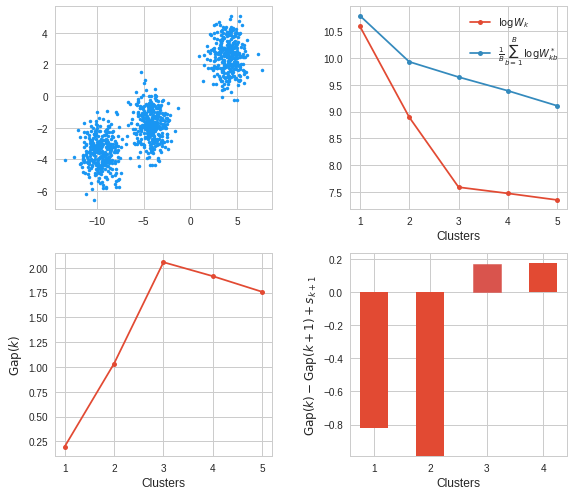

In [22]:
X, _ = make_blobs(n_samples=1000, centers=3, cluster_std=1)
ks, Wks, sample_Wks, gaps, sk = gap_stats(X, K=5)
gaps_info(X, ks, Wks, sample_Wks, gaps, sk)

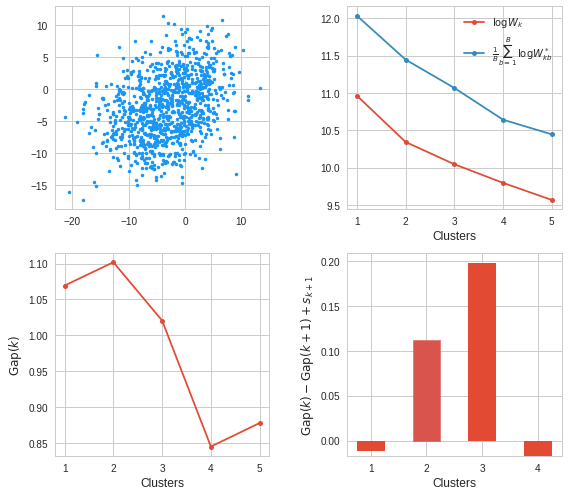

In [23]:
X, _ = make_blobs(n_samples=1000, centers=3, cluster_std=4)
ks, Wks, sample_Wks, gaps, sk = gap_stats(X, K=5)
gaps_info(X, ks, Wks, sample_Wks, gaps, sk)

As we can see, the two figures give several resukts for the number of cluster we should use. Even if the two distributions are initialized with 3 centers (gaussian), we don't have the same number which is compute.

An increase of standard deviation reduces the number of cluster we should use. 

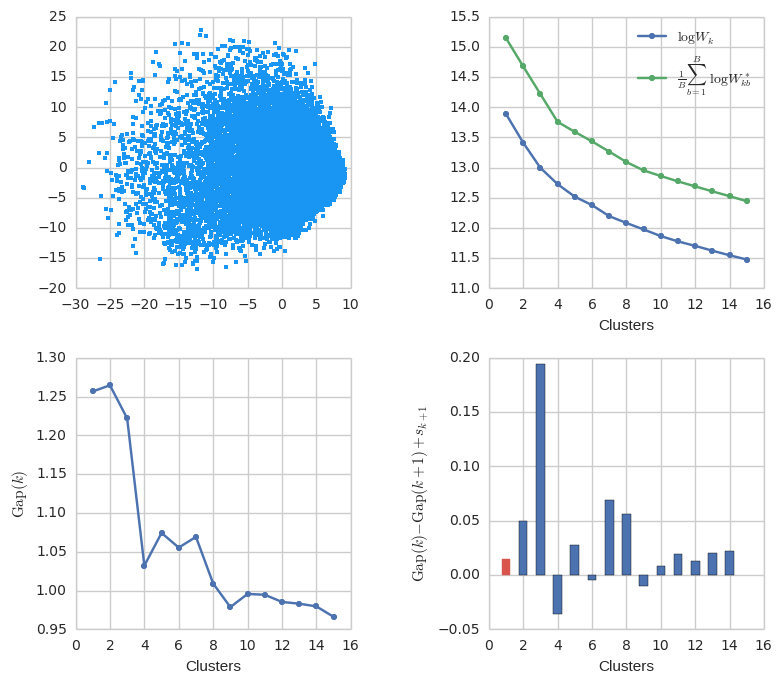

In [10]:
from time import time
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import seaborn as sns

    
data=[]
for i in range(int(len(digits)*0.25)):
    data.append(digits[i][1])
data = scale(data)


# Even if the results aren't as good with PCA, for this first implementation it will be useful to stay with it
# Or we need to compute Monte carlo in 784-
reduced_data = PCA(n_components=2).fit_transform(data) # Redced data to plot them in 2D

    
ks, Wks, sample_Wks, gaps, sk = gap_stats(reduced_data, K=15)
gaps_info(reduced_data, ks, Wks, sample_Wks, gaps, sk)

On this figure we can see the difficulty of Kmeans algorithm to mNIST data, in particularly for reduced PCA datas. We should try it on the full set.

------------------------------------------------

### Method b à faire pour l'estimation en dim 784

## IV   Variations on the K-means method

Can use kernel instead of Frobenius to obtain non linear feature : gaussian, poly,tanh
See : http://www.cs.ucsb.edu/~veronika/MAE/Global_Kernel_K-Means.pdf

In [203]:
def pairwise_distances_argmin_kernel_gaussian(X, y):
    '''
    Return the closest centroids to the point y
    X are all the centroids
    Exponential distance
    '''
    indices = np.empty(X.shape[0], dtype=np.intp)
    for i in range(len(X)):
        indices[i] = np.exp(-(np.linalg.norm(X[i,np.newaxis] - y, axis=1)**2)*10).argmin()
    return indices

def pairwise_distances_argmin_kernel_pol(X, y):
    '''
    Return the closest centroids to the point y
    X are all the centroids
    Exponential distance
    '''
    indices = np.empty(X.shape[0], dtype=np.intp)
    for i in range(len(X)):
        indices[i] = ((X[i]*y)**3).argmin()
        
    return indices

In [190]:
k=10
m, clusters = kmeans(validation_data, k,pairwise_distances_argmin_kernel_gaussian)
labelled_centroids = assign_labels_to_centroids(clusters,m)
error_rate = get_error_rate(validation, labelled_centroids)

print(error_rate)

/home/kevin/miniconda3/envs/ipykernel_py3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/kevin/miniconda3/envs/ipykernel_py3/lib/python3.6/site-packages/numpy/core/_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


KeyboardInterrupt: 

In [204]:
X, _ = make_blobs(n_samples=10, centers=3, cluster_std=2.8)
m, clusters = kmeans(X, 3,pairwise_distances_argmin_kernel_pol)
plt.title('Results of Lloyds algorithm for {} clusters, with standard deviation {}' .format(k,sigma))
plot_clusters(X, m, clusters)


/home/kevin/miniconda3/envs/ipykernel_py3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/kevin/miniconda3/envs/ipykernel_py3/lib/python3.6/site-packages/numpy/core/_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


KeyboardInterrupt: 

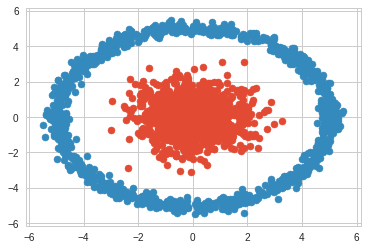

In [16]:
plt.figure(2)
plt.scatter(np.random.normal(size=1000),np.random.normal(size=1000))
r=np.random.normal(loc=5,scale=0.2,size=1000)
theta=np.random.uniform(0,2*np.pi,size=1000)
plt.scatter(r*np.cos(theta),r*np.sin(theta))
plt.show()

In [17]:
data1=np.random.normal(size=(1000,2))
#data1y=np.random.normal(size=250)
#data1=np.concatenate((data1x,data1y),axis=1)
#print(data1)
data2x=r*np.cos(theta)
data2y=r*np.sin(theta)

data2=np.zeros((1000,2))
for i in range(1000):
    data2[i][0]=data2x[i]
    data2[i][1]=data2y[i]
#data2=zip(data2x,data2y)

data=np.concatenate((data1,data2),axis=0)
np.random.shuffle(data)

make_animation(data, k=2, frames=20)


In [18]:
class KMeansAnimation_polar:
    def __init__(self, fig, ax, X, m=None, k=2):
        self.X = X
        self.fig = fig
        self.m = m 
        # We have to call plot for each cluster and its centroid
        # because we want to distinguish the clusters by color
        # and draw the centroid with a different marker
        self.clusters, self.centroids = [], []
        for i in range(k):
            color = cmap(i / k)
            self.clusters.append(
                ax.plot([], [],
                        linestyle='', marker='.',
                        markeredgecolor=color, color=color)[0]
            )
            self.centroids.append(
                ax.plot([], [],
                        linestyle='', marker='s',
                        markeredgewidth=1,
                        markersize=8, color=color,markeredgecolor='k')[0]
            )
      
    def update(self, t):
        self.m, clusters = kmeans_iteration(self.X, self.m)
        self.fig.suptitle('n = {}, centers = {} – Iteration {}'.format(
                len(self.X), len(self.m), t + 1)
        )
        # To update the plot, we simply call set_data on the saved axes
        for i in range(len(self.m)):
            group = self.X[clusters == i]
            for l in range(len(group)): group[l]=pol2cart(group[l][1],group[l][0])
            #print (group)
            self.clusters[i].set_data(group.T)
            self.centroids[i].set_data(pol2cart(self.m[i][1],self.m[i][0]))
        return self.clusters + self.centroids

In [19]:
def make_animation_polar(X, k, m=None, frames=20):
    '''
    display animation in jupyter notebook
    '''
    fig = plt.figure(figsize=(6, 4))
    (xmin, ymin), (xmax, ymax) = np.min(X, axis=0), np.max(X, axis=0)
    
    ax = plt.axes(xlim=(-5, 5), ylim=(-5, 5))
    #ax = plt.subplot((111),polar=True)
    control = KMeansAnimation_polar(fig, ax, X, m=m, k=k)
    anim = animation.FuncAnimation(
        fig, control.update,
        frames=frames, interval=700, blit=True,
    )
    # Necessary, otherwise the notebook will display the final figure
    # along with the animation
    plt.close(fig)
    return HTML(anim.to_html5_video())

In [20]:
r=np.random.normal(loc=4,scale=0.3,size=1000)
theta=np.random.uniform(0,2*np.pi,size=1000)
data2pol = np.zeros((1000,2))

def z2polar(z):
    return ( np.abs(z), np.angle(z) )

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return np.array([x, y])

data1=np.random.normal(loc=(0,0),scale=0.8,size=(1000,2))
data1pol=np.zeros((1000,2))
for i in range(1000):
    z,angle = z2polar(data1[i][0]+1j*data1[i][1])
    
    data1pol[i][1] = z
    data1pol[i][0]=angle
    data2pol[i][1] = r[i]
    data2pol[i][0]=theta[i]
    
data=np.concatenate((data1pol,data2pol),axis=0)
np.random.shuffle(data)    

m = np.array([[0, 2.5], [0, 3]])
make_animation_polar(data, k=2,m=m, frames=20)


Limits to kmeans : http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py